<a href="https://colab.research.google.com/github/elgevan/promba/blob/main/Hurricane_Landfall_USA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from bs4 import BeautifulSoup
import pandas as pd
import requests
import matplotlib.pyplot as plt
import re

In [2]:
def html_table_to_dataframe(html_file_path):
  """
  Reads an HTML file, extracts the first table, and converts it into a pandas DataFrame.
  Rows with only one column are excluded.

  Args:
    html_file_path: The path to the HTML file.

  Returns:
    A pandas DataFrame representing the table data, or None if no table is found or an error occurs.
  """
  try:
    with open(html_file_path, 'r', encoding='utf-8') as f:
      html_content = f.read()

    soup = BeautifulSoup(html_content, 'html.parser')
    table = soup.find('table')

    if table is None:
      print("No table found in the HTML file.")
      return None

    # Extract table rows
    rows = []
    for tr in table.find_all('tr'):
        row_data = []
        for td in tr.find_all(['td', 'th']):
            row_data.append(td.text.strip())
        if row_data and len(row_data) > 1:
            rows.append(row_data)

    if not rows:
        print("No valid rows found in the table (all rows had one or zero columns).")
        return None

    # Use the first row as column names
    headers = rows[0]
    data_rows = rows[1:]

    df = pd.DataFrame(data_rows, columns=headers)

    return df

  except FileNotFoundError:
    print(f"Error: File not found at path: {html_file_path}")
    return None
  except Exception as e:
    print(f"An error occurred: {e}")
    return None

# HTML retrieved from https://www.aoml.noaa.gov/hrd/hurdat/All_U.S._Hurricanes.html?print=yes
file_path = '/content/US hurricane landfalls.html'
df = html_table_to_dataframe(file_path)
df.to_csv('hurricane-data.csv', index=False)

In [3]:
def find_highest_category_storm(text):
  """
  Finds the highest digit in a string.
  Args:
    text: The input string.
  Returns:
    The highest single-digit integer found in the string, or NaN if no digit is found.
  """
  digits = re.findall(r'\d', str(text))
  if digits:
    return max(map(int, digits))
  else:
    return 0

df['Storm Category'] = df['States Affected and Category by States'].apply(find_highest_category_storm)

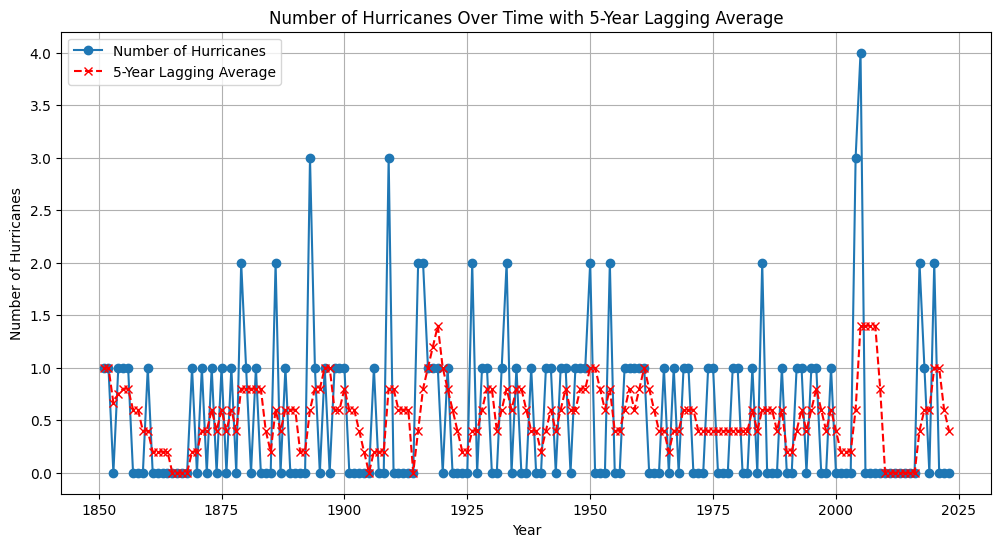

In [4]:
df['Year'] = pd.to_numeric(df['Year'], errors='coerce')
hurricane_data = df.query("`Storm Category` in [3, 4, 5] and Year <= 2020")
hurricanes_by_year = hurricane_data.groupby('Year').size().reset_index(name='HurricaneCount')
# Create a DataFrame with all years in your original data
all_years = pd.DataFrame({'Year': range(df['Year'].min(), df['Year'].max() + 1)})
# Merge with the hurricanes_by_year DataFrame to include years with zero counts
hurricanes_by_year = pd.merge(all_years, hurricanes_by_year, on='Year', how='left').fillna(0)
hurricanes_by_year['LaggingAverage'] = hurricanes_by_year['HurricaneCount'].rolling(window=5, min_periods=1).mean()

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(hurricanes_by_year['Year'], hurricanes_by_year['HurricaneCount'], label='Number of Hurricanes', marker='o', linestyle='-')
plt.plot(hurricanes_by_year['Year'], hurricanes_by_year['LaggingAverage'], label='5-Year Lagging Average', marker='x', linestyle='--', color='red')

# Customize the plot
plt.xlabel('Year')
plt.ylabel('Number of Hurricanes')
plt.title('Number of Hurricanes Over Time with 5-Year Lagging Average')
plt.legend()
plt.grid(True)
plt.show()